In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from IPython.core.display import display, HTML

# display wide notebook cells
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import sys  
sys.path.insert(0, 'Code')

import feature_importance
import feature_selection
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import taxa
import train_and_predict
import util


from data import *
from train_and_predict import *
from visualization import *

from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

# Read Data

In [5]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
path = Path('..\Data')

In [6]:
figs_output = Path('Paper\Figures')

In [8]:
train_genomes_path = path / 'train_genomes.fasta'
train_genomes_metedata_path = path / 'train_genomes_info.csv'

test_genomes_path = path / 'test_genomes.fasta'
test_genomes_metedata_path = path / 'test_genomes_verified.csv'

train_dataset = GenomesData(train_genomes_path, train_genomes_metedata_path)
test_dataset = GenomesData(test_genomes_path, test_genomes_metedata_path)

Check split train dataset to train and validation according to insertion date

In [9]:
print('train dataset', len(train_dataset.data))

split = feature_selection.split_by_insertion_date(train_dataset, proportion=0.2)

train_idx, validation_idx = next(split.split())

X_train_raw, X_valid_raw = train_dataset.data[train_idx], train_dataset.data[validation_idx]
y_train, y_valid = train_dataset.y[train_idx], train_dataset.y[validation_idx]

print('train', len(X_train_raw), 'validation', len(X_valid_raw))

train dataset 641
train 513 validation 128


In [9]:
y_valid.value_counts()

1    89
0    39
Name: Label, dtype: int64

In [10]:
DATE_INSERTED = 'Date Inserted'

min_validation_date = min(train_dataset.metadata.iloc[validation_idx, :][DATE_INSERTED])
min_validation_date

Timestamp('2018-11-29 03:53:53.656000+0000', tz='UTC')

In [11]:
max_train_date = max(train_dataset.metadata.iloc[train_idx, :][DATE_INSERTED])
max_train_date

Timestamp('2018-11-29 03:08:47.637000+0000', tz='UTC')

In [12]:
assert min_validation_date > max_train_date

# Feature Selection - best k features according to chi2

## 20% validation

In [10]:
min_val = 50
max_val = 600
inc = 50

k_range = range(min_val, max_val + 1, inc)

split = feature_selection.split_by_insertion_date(train_dataset, proportion=0.2)
grid_search = feature_selection.perform_fs_k_best(train_dataset, k_range, split=split)
print(grid_search.best_params_)

param_name = 'k_best__k'
kvals_df = feature_selection.grid_search_results_to_df(grid_search, param_name)

Best roc_auc score is: 0.9030538749639873
{'k_best__k': 450}


In [9]:
kvals_df

,mean_test_balanced_accuracy,mean_test_roc_auc
param_k_best__k,,
50,0.832,0.873
100,0.828,0.885
150,0.813,0.882
200,0.815,0.897
250,0.826,0.896
300,0.837,0.896
350,0.837,0.898
400,0.832,0.899
450,0.844,0.903


Validation results per k value


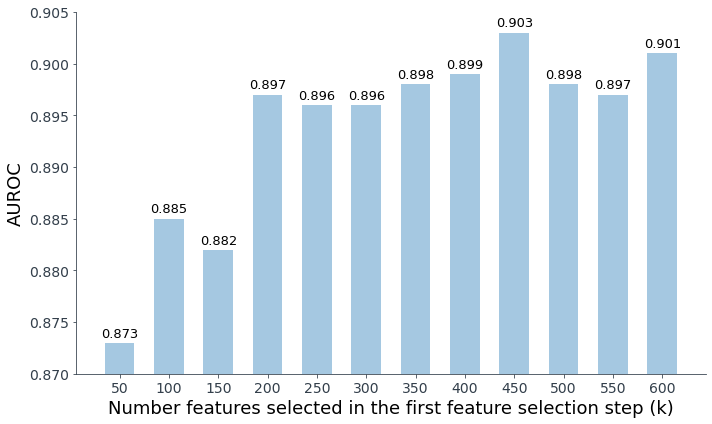

In [37]:
print('Validation results per k value')

fig_path = figs_output / 'feat_selection_k.png'

fs_dict = dict(zip(list(kvals_df.index), list(kvals_df['mean_test_roc_auc'])))
create_barplots(fs_dict, width=30, x_label='Number features selected in the first feature selection step (k)', y_label=AUROC, out_path=fig_path, round_by=3, bar_label_font_size=13, save=True)

# Feature Selection - select best feature from each cluster

In [23]:
min_val = 0
max_val = 0.85
inc = 0.06
t_range = np.arange(min_val, max_val, inc)

# created corr matrix using feature_selection.create_corr_matrix(X_train_raw, y_train) 
corr_matrix_path = path / 'X_train_corr_mat_0.8_k450.csv'
corr_matrix_train = pd.read_csv(corr_matrix_path, index_col=0)
dist_matrix_train = feature_selection.feature_corr_to_dist_matrix(corr_matrix_train)

split = feature_selection.split_by_insertion_date(train_dataset, proportion=0.2)
grid_search_cluster = feature_selection.perform_fs_clusters(train_dataset, dist_matrix_train, t_range, split=split)
print(grid_search_cluster.best_params_)

param_name = 'cluster__threshold'
thresholds_df = feature_selection.grid_search_results_to_df(grid_search_cluster, param_name)

threshold=0.00, selected_features=450
threshold=0.06, selected_features=373
threshold=0.12, selected_features=298
threshold=0.18, selected_features=244
threshold=0.24, selected_features=201
threshold=0.30, selected_features=159
threshold=0.36, selected_features=116
threshold=0.42, selected_features=74
threshold=0.48, selected_features=47
threshold=0.54, selected_features=30
threshold=0.60, selected_features=15
threshold=0.66, selected_features=8
threshold=0.72, selected_features=5
threshold=0.78, selected_features=2
threshold=0.84, selected_features=1
threshold=0.00, selected_features=450
Best roc_auc score is: 0.9030538749639873
{'cluster__threshold': 0.0}


In [24]:
thresholds_df

,mean_test_balanced_accuracy,mean_test_roc_auc
param_cluster__threshold,,
0.00,0.844,0.903
0.06,0.843,0.898
0.12,0.843,0.901
0.18,0.850,0.903
0.24,0.850,0.900
0.30,0.856,0.893
0.36,0.850,0.892
0.42,0.839,0.897
0.48,0.844,0.896


Validation results per threshold value


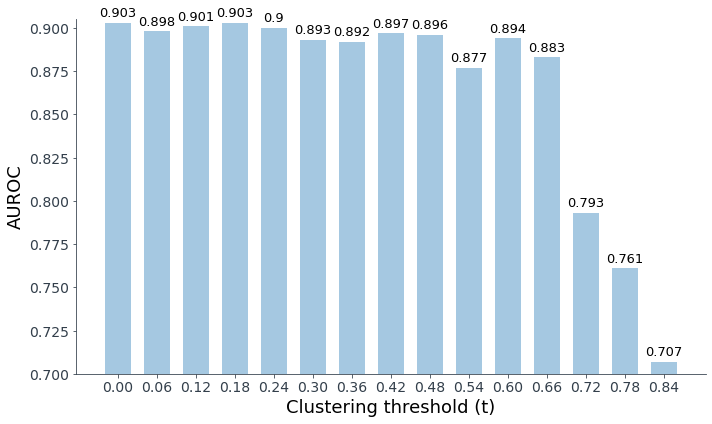

In [38]:
print('Validation results per threshold value')

fig_path = figs_output / 'feat_selection_t.png'
fs_dict = dict(zip(list(thresholds_df.index), list(thresholds_df['mean_test_roc_auc'])))

create_barplots(fs_dict, width=0.04, x_label='Clustering threshold (t)', y_label=AUROC, out_path=fig_path, round_by=3, bar_label_font_size=13, y_lim=[0.7, 0.905], save=True)

# Validation Results

In [33]:
best_k = 450
best_t = 0.18

## Correlation 0.8 of train

In [34]:
fs_pipeline = feature_selection.get_fs_pipeline(dist_matrix_train, k=best_k, threshold=best_t)
fs_pipeline.fit(X_train_raw, y_train)

all_pgfams_train = pd.array(fs_pipeline['vectorize'].get_feature_names())
k_best_pgfams_train = all_pgfams_train[fs_pipeline['k_best'].get_support()]
cluster_pgfams_train = k_best_pgfams_train[fs_pipeline['cluster'].get_support()]

threshold=0.18, selected_features=244


In [35]:
corr_matrix_train_clust = corr_matrix_train.loc[cluster_pgfams_train, cluster_pgfams_train]

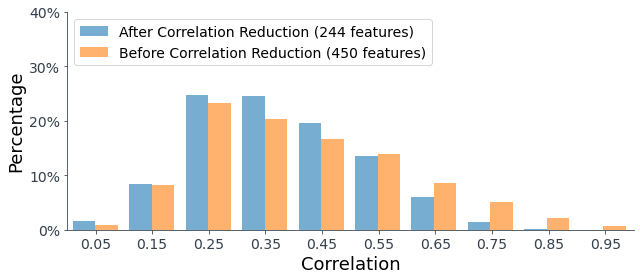

In [77]:
corr_clust_matrix = corr_matrix_train_clust
corr_all_matrix = corr_matrix_train

NO_CORR_REDUCTION = f'Before Correlation Reduction ({len(corr_all_matrix)} features)'
CORR_REDUCTION = f'After Correlation Reduction ({len(corr_clust_matrix)} features)'

corr_clust = [i for i in corr_matrix_train_clust.values.flatten() if i != 1]
corr_all = [i for i in corr_matrix_train.values.flatten() if i != 1]

dataset_names = [CORR_REDUCTION, NO_CORR_REDUCTION]

fig_path = figs_output / 'feature_correlation_train_without_valid.png'

create_correlation_plot(corr_clust, corr_all, dataset_names, out_path=fig_path, fig_size=(9, 4), save=True)

no clustering

In [50]:
fs_pipeline = feature_selection.get_fs_pipeline(dist_matrix_train, k=best_k, threshold=0)

fs_pipeline.fit(X_train_raw, y_train)

results_valid_no_clust = predict_and_print_results(X_valid_raw, y_valid, fs_pipeline)

threshold=0.00, selected_features=450
false_positive: 6,total NHPs: 39
false_negative: 14,total HPs: 89
BACC: 0.84
Sensitivity: 0.84
Specificity: 0.85
AUPR: 0.95
AUROC: 0.9


In [52]:
fs_pipeline = feature_selection.get_fs_pipeline(dist_matrix_train, k=best_k, threshold=best_t)

fs_pipeline.fit(X_train_raw, y_train)

results_valid = predict_and_print_results(X_valid_raw, y_valid, fs_pipeline)

threshold=0.18, selected_features=244
false_positive: 6,total NHPs: 39
false_negative: 13,total HPs: 89
BACC: 0.85
Sensitivity: 0.85
Specificity: 0.85
AUPR: 0.94
AUROC: 0.9


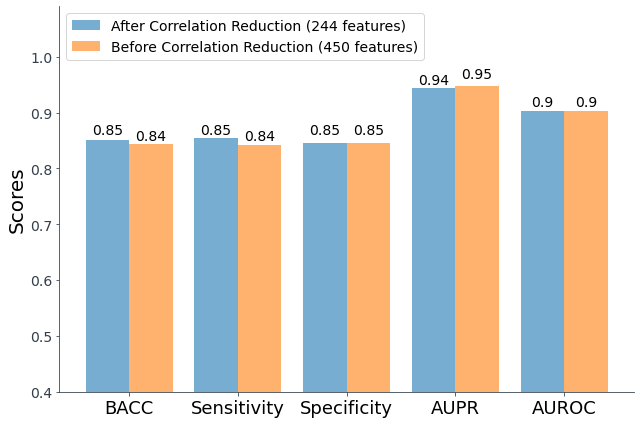

In [78]:
bar_groups = [BACC, SEN, SPE, AUPR, AUROC]
bars = [CORR_REDUCTION, NO_CORR_REDUCTION]

results_for_plot = {NO_CORR_REDUCTION: results_valid_no_clust, CORR_REDUCTION: results_valid}

fig_path = figs_output / 'validation_results.png'
create_grouped_barplots(results_for_plot, bar_groups, bars, out_path=fig_path, fig_size=(9, 6), bar_width=0.4, legend_loc='upper left', x_ticks_font_size=18, y_lim=[0.4, 1.09], save=True)

# Final model

## Perform feature selection process on the entire train dataset, using best parameters

In [90]:
best_k = 450
best_t = 0.18

In [91]:
X_train_dataset_raw, X_test_raw = train_dataset.data, test_dataset.data
y_train_dataset, y_test = train_dataset.y, test_dataset.y

# created corr matrix using feature_selection.create_corr_matrix(X_train_dataset_raw, y_train, k=450) 
corr_matrix_path = path / 'X_train_corr_mat_k450.csv'
X_train_corr_matrix_k450 = pd.read_csv(corr_matrix_path, index_col=0)
X_train_dist_mat = feature_selection.feature_corr_to_dist_matrix(X_train_corr_matrix_k450)

fs_pipeline = feature_selection.get_fs_pipeline(X_train_dist_mat, k=best_k, threshold=best_t)

fs_pipeline.fit(X_train_dataset_raw, y_train_dataset)

results = predict_and_print_results(X_test_raw, y_test, fs_pipeline)

threshold=0.18, selected_features=250
false_positive: 21,total NHPs: 102
false_negative: 6,total HPs: 102
BACC: 0.87
Sensitivity: 0.94
Specificity: 0.79
AUPR: 0.96
AUROC: 0.95


In [10]:
y_train_dataset.value_counts()

1    428
0    213
Name: Label, dtype: int64

## Extract final features

In [92]:
all_pgfams = pd.array(fs_pipeline['vectorize'].get_feature_names())
k_best_pgfams = all_pgfams[fs_pipeline['k_best'].get_support()]
cluster_pgfams = k_best_pgfams[fs_pipeline['cluster'].get_support()]

# Examine features

In [44]:
len(all_pgfams)

393042

In [51]:
vectorizer = CountVectorizer(lowercase=False, binary=True, vocabulary=cluster_pgfams)
X_train_fs_clust = train_dataset.vectorize_data(vectorizer)

In [52]:
assert all(cluster_pgfams == vectorizer.get_feature_names())

In [53]:
assert all(cluster_pgfams == X_train_fs_clust.columns)

In [54]:
vectorizer = CountVectorizer(lowercase=False, binary=True, vocabulary=k_best_pgfams)
X_train_fs_k_best = train_dataset.vectorize_data(vectorizer)

In [55]:
chi2_vals, __ = sklearn.feature_selection.chi2(X_train_fs_k_best, train_dataset.y)
min(chi2_vals)

68.3802547338115

In [109]:
X_train_fs_k_best_hp = X_train_fs_k_best.loc[:, set(pgfam_to_count_hp.keys()).intersection(X_train_fs_k_best.columns)]
X_train_fs_k_best_nhp = X_train_fs_k_best.loc[:, set(pgfam_to_count_nhp.keys()).intersection(X_train_fs_k_best.columns)]

chi2_vals_fs_k_best_hp, __ = sklearn.feature_selection.chi2(X_train_fs_k_best_hp, train_dataset.y)
chi2_vals_fs_k_best_nhp, __ = sklearn.feature_selection.chi2(X_train_fs_k_best_nhp, train_dataset.y)

In [110]:
min(chi2_vals_fs_k_best_hp)

68.40863609279273

In [111]:
min(chi2_vals_fs_k_best_nhp)

68.3802547338115

In [50]:
def get_hp_to_nhp_count(X, y, pgfam):
    return feature_importance.count_hp_vs_nhp(X[X[pgfam]==1].index, y)


pgfam_to_count_hp = {}
pgfam_to_count_nhp = {}

for pgfam in k_best_pgfams:
    hp, nhp = get_hp_to_nhp_count(X_train_fs_k_best, train_dataset.y, pgfam)
    if hp > nhp:
        pgfam_to_count_hp[pgfam] = hp
    else:
        pgfam_to_count_nhp[pgfam] = nhp


min(pgfam_to_count_hp.values()), min(pgfam_to_count_nhp.values())

(139, 35)

In [112]:
vectorizer = CountVectorizer(lowercase=False, binary=True, vocabulary=cluster_pgfams)
X_train_final_features = train_dataset.vectorize_data(vectorizer)

X_train_final_features_hp = X_train_final_features.loc[:, set(pgfam_to_count_hp.keys()).intersection(X_train_final_features.columns)]
X_train_final_features_nhp = X_train_final_features.loc[:, set(pgfam_to_count_nhp.keys()).intersection(X_train_final_features.columns)]

chi2_vals_final_hp, __ = sklearn.feature_selection.chi2(X_train_final_features_hp, train_dataset.y)
chi2_vals_final_nhp, __ = sklearn.feature_selection.chi2(X_train_final_features_nhp, train_dataset.y)

In [113]:
chi2_final_feats_hp = pd.Series(chi2_vals_final_hp, index=X_train_final_features_hp.columns)
chi2_final_feats_hp = chi2_final_feats_hp.sort_values(ascending=False)
chi2_final_feats_hp.head()

PGF_07157721    123.013500
PGF_04139053    121.163670
PGF_00006100    113.372253
PGF_00022550    112.402208
PGF_02280536    112.113190
dtype: float64

In [51]:
chi2_final_feats_nhp = pd.Series(chi2_vals_final_nhp, index=X_train_final_features_nhp.columns)
chi2_final_feats_nhp = chi2_final_feats_nhp.sort_values(ascending=False)
chi2_final_feats_nhp.head()

PGF_01667671    224.781054
PGF_02930287    211.080374
PGF_00033940    190.387663
PGF_10332317    185.342548
PGF_00401757    183.450463
dtype: float64

In [52]:
pgfams = {}

with open(path / 'PATRIC_pgfams_wspc.txt') as f:
    header = f.readline()

    for line in f:
        pgfam, product = line.strip().split('\t')
        pgfams[pgfam] = product

In [53]:
for pgfam in chi2_final_feats_hp.index[:15]:
    print(pgfams[pgfam])

"Heme O synthase, protoheme IX farnesyltransferase, COX10-CtaB"
Uroporphyrinogen III decarboxylase (EC 4.1.1.37)
tRNA-modifying protein YgfZ
Molybdopterin synthase catalytic subunit MoaE (EC 2.8.1.12)
Dienelactone hydrolase family protein
"YpfJ protein, zinc metalloprotease superfamily"
Cell division protein FtsQ
Deoxyribodipyrimidine photolyase (EC 4.1.99.3)
Cytosol aminopeptidase PepA (EC 3.4.11.1)
Flavodoxin reductases (ferredoxin-NADPH reductases) family 1
NADH-ubiquinone oxidoreductase chain E (EC 1.6.5.3)
Tol-Pal system protein TolQ
Nitrite reductase [NAD(P)H] large subunit (EC 1.7.1.4)
Luciferase-like monooxygenase YhbW
UPF0061 protein YdiU


In [54]:
for pgfam in chi2_final_feats_nhp.index[:15]:
    print(pgfams[pgfam])

Cytidylate kinase (EC 2.7.4.25)
Reverse rubrerythrin
Phosphoribosylaminoimidazolecarboxamide formyltransferase (EC 2.1.2.3)
Electron transport complex protein RnfB
no significant homology.
Flavoprotein
[FeFe] hydrogenase (EC 1.12.7.2)
Rubrerythrin
Activator of (R)-2-hydroxyglutaryl-CoA dehydratase
"Dihydroorotate dehydrogenase (NAD(+)), catalytic subunit (EC 1.3.1.14)"
Iron-sulfur flavoprotein
"L,L-diaminopimelate aminotransferase (EC 2.6.1.83)"
"RNA methyltransferase, TrmA family"
Flavodoxin
Flavoredoxin


#### Observe clusters to make sure they make sense

In [55]:
clusters = fs_pipeline['cluster'].clusters_
clusters.sort(key=lambda cluster: len(cluster), reverse=True)

In [56]:
for i, cluster in enumerate(clusters):
    print('cluster', i)
    for pgfam_ind in cluster:
        pgfam = k_best_pgfams[pgfam_ind]
        print(pgfam, pgfams[pgfam])
    print('-----------------')

cluster 0
PGF_00000939 Uncharacterized protein YhiN
PGF_00008469 Glutathione synthetase (EC 6.3.2.3)
PGF_00019484 Membrane alanine aminopeptidase N (EC 3.4.11.2)
PGF_00031127 Periplasmic thiol:disulfide interchange protein DsbA
PGF_00054476 Succinate dehydrogenase hydrophobic membrane anchor protein
PGF_00057016 "Tol biopolymer transport system, TolR protein"
PGF_00057028 Tol-Pal system peptidoglycan-associated lipoprotein PAL
PGF_00064460 Ubiquinone biosynthesis regulatory protein kinase UbiB
PGF_00064685 Uncharacterized ferredoxin-like protein YfhL
PGF_00415581 23S rRNA (uridine(2552)-2'-O)-methyltransferase (EC 2.1.1.166)
PGF_00417755 3-demethylubiquinol 3-O-methyltransferase (EC 2.1.1.64) @ 2-polyprenyl-6-hydroxyphenyl methylase (EC 2.1.1.222)
PGF_00423927 4-hydroxybenzoate polyprenyltransferase (EC 2.5.1.39)
PGF_00648054 Tol-Pal system protein TolQ
PGF_00649271 Cell division protein BolA
PGF_00906364 Hydroxyacylglutathione hydrolase (EC 3.1.2.6)
PGF_01785347 Adenosine (5')-pentaph

cluster 161
PGF_02737404 Trehalose-6-phosphate phosphatase (EC 3.1.3.12)
-----------------
cluster 162
PGF_02818638 Hemolysins and related proteins containing CBS domains
-----------------
cluster 163
PGF_02854165 hypothetical protein
-----------------
cluster 164
PGF_02904191 NifU-related domain containing protein
-----------------
cluster 165
PGF_02905791 Multicopper oxidase
-----------------
cluster 166
PGF_03013281 Bis-ABC ATPase CAC0528
-----------------
cluster 167
PGF_03081665 "Cell division integral membrane protein, YggT and half-length relatives"
-----------------
cluster 168
PGF_03244749 Bis-ABC ATPase SPy1206
-----------------
cluster 169
PGF_03427698 "3',5'-cyclic-nucleotide phosphodiesterase (EC 3.1.4.17)"
-----------------
cluster 170
PGF_03439827 Precorrin-2 oxidase (EC 1.3.1.76) @ Sirohydrochlorin ferrochelatase activity of CysG (EC 4.99.1.4) / Uroporphyrinogen-III methyltransferase (EC 2.1.1.107)
-----------------
cluster 171
PGF_03647550 UPF0234 protein Yitk
--------

# Correlation entire train

In [57]:
X_train_250_feats_corr_mat = X_train_corr_matrix_k450.loc[cluster_pgfams, cluster_pgfams]

In [58]:
X_train_250_feats_corr_mat.head()

,PGF_00003251,PGF_00004164,PGF_00004169,PGF_00004337,PGF_00006100,PGF_00006245,PGF_00006320,PGF_00006377,PGF_00006380,PGF_00007119,...,PGF_10368922,PGF_10424554,PGF_10470483,PGF_10471787,PGF_10474010,PGF_10506571,PGF_10522720,PGF_10535492,PGF_12758906,PGF_12946886
PGF_00003251,1.000000,0.045217,0.116374,0.168262,0.360630,0.346004,0.346004,0.213321,0.311025,0.364685,...,0.142193,0.214516,0.165513,0.162796,0.286988,0.339711,0.017465,0.293345,0.310118,0.246512
PGF_00004164,0.045217,1.000000,0.330269,0.359142,0.349617,0.268387,0.188720,0.430382,0.249400,0.166379,...,0.272495,0.209224,0.217689,0.247273,0.275260,0.265726,0.530056,0.252031,0.161876,0.224426
PGF_00004169,0.116374,0.330269,1.000000,0.625801,0.373544,0.340748,0.331439,0.443322,0.287668,0.471309,...,0.688182,0.190276,0.410318,0.140015,0.292063,0.260030,0.497373,0.269891,0.351861,0.438752
PGF_00004337,0.168262,0.359142,0.625801,1.000000,0.371939,0.339613,0.349120,0.388367,0.249351,0.348001,...,0.590163,0.192658,0.600034,0.321628,0.292962,0.268000,0.411042,0.270487,0.493369,0.458840
PGF_00006100,0.360630,0.349617,0.373544,0.371939,1.000000,0.648785,0.648785,0.592796,0.557968,0.549171,...,0.345447,0.584820,0.289622,0.302283,0.729813,0.735041,0.425072,0.760420,0.273308,0.469013


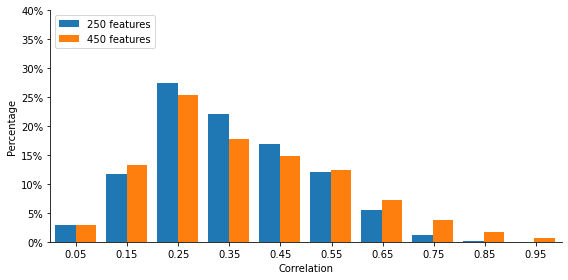

In [59]:
corr_clust_matrix = X_train_250_feats_corr_mat
corr_all_matrix = X_train_corr_matrix_k450

corr_clust = [i for i in corr_clust_matrix.values.flatten() if i != 1]
corr_all = [i for i in corr_all_matrix.values.flatten() if i != 1]

dataset_names = dataset_names = [f'{len(corr_clust_matrix)} features', f'{len(corr_all_matrix)} features']

fig_path = figs_output / 'feature_correlation_entire_train.pdf'

create_correlation_plot(corr_clust, corr_all, dataset_names, out_path=fig_path)

## Final WSPC model
A random forest model, which includes the selected genes as features

In [93]:
WSPC, results = train_and_predict(X_train_dataset_raw, y_train_dataset, X_test_raw, y_test, features=cluster_pgfams)

false_positive: 21,total NHPs: 102
false_negative: 6,total HPs: 102
BACC: 0.87
Sensitivity: 0.94
Specificity: 0.79
AUPR: 0.96
AUROC: 0.95


In [94]:
predictions, predictions_probs = predict(X_test_raw, WSPC)

In [62]:
predict_df = pd.DataFrame({'predictions':predictions, 'predictions_probs':predictions_probs}, index=X_test_raw.index)
predict_df.head()

,predictions,predictions_probs
Genome ID,,
163603.4,1,0.62
648.157,1,0.98
565.15,1,0.93
29459.655,1,1.00
87883.284,1,0.99


In [13]:
save = False

if save:
    #save predictions

    predict_df.to_csv(path/'WSPC_test_preds'/'wspc_test_preds.csv')
    
    #save model
    out_path = r'WSPC Model'
    model_filename = 'WSPC_model'
    util.save_model(out_path, model_filename, WSPC)

## Novel species

All classified species in train

In [80]:
train_species = taxa.get_genomes_species(train_dataset.data.index)
len(train_species)

536

In [81]:
train_genera = taxa.get_genomes_tax(train_dataset.data.index, taxa.GENUS)
len(train_genera)

200

Genera in test

In [82]:
test_genera = taxa.get_genomes_tax(test_dataset.data.index, taxa.GENUS)
len(test_genera)

93

All classified species in test

In [83]:
test_species = taxa.get_genomes_species(test_dataset.data.index)

In [84]:
len(test_species)

169

In [85]:
test_species_not_in_train = taxa.get_novel_species(train_dataset.data.index, test_dataset.data.index)

In [86]:
len(test_species_not_in_train)

63

In [87]:
test_novel_genome_ids = taxa.get_genomes_with_tax(test_dataset.data.index, test_species_not_in_train, taxa.SPECIES)

In [95]:
novel_species_results = predict_and_print_results(X_test_raw[test_novel_genome_ids], y_test[test_novel_genome_ids], WSPC)

false_positive: 7,total NHPs: 31
false_negative: 6,total HPs: 32
BACC: 0.79
Sensitivity: 0.81
Specificity: 0.77
AUPR: 0.89
AUROC: 0.87


# Plot Results

In [96]:
ENTIRE_TEST = 'Entire Test'
NOVEL_SPECIES = 'Novel Species'

In [97]:
results_for_plot = {ENTIRE_TEST: results, NOVEL_SPECIES: novel_species_results}

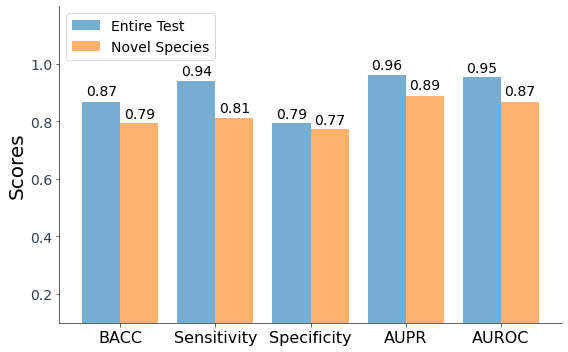

In [103]:
bar_groups = [BACC, SEN, SPE, AUPR, AUROC]
bars = [ENTIRE_TEST, NOVEL_SPECIES]

fig_path = figs_output / 'wspc_test_results.pdf'
create_grouped_barplots(results_for_plot, bar_groups, bars, out_path=fig_path, fig_size=(8, 5), bar_width=0.4, legend_loc='upper left', y_lim=(0.1, 1.199), x_ticks_font_size=16)